In [3]:
!pip install metpy

In [2]:
import scipy
import pandas as pd
import xarray as xr
import numpy as np
# from utils import summa_check
from utils import lw_clr
from metpy.units import units
import metpy.calc as mpcalc

In [4]:
# Load template forcing file with correct attributes
template = xr.open_dataset('copy_prr_2010-2014.nc')
template

<xarray.Dataset>
Dimensions:         (time: 72719, hru: 1)
Coordinates:
  * time            (time) datetime64[ns] 2010-11-08T00:30:00 ... 2014-12-31T...
Dimensions without coordinates: hru
Data variables: (12/16)
    airpres         (time, hru) float64 ...
    airtemp         (time, hru) float64 ...
    spechum         (time, hru) float64 ...
    windspd         (time, hru) float64 ...
    SWRadAtm        (time, hru) float64 ...
    LWRadAtm        (time, hru) float64 ...
    ...              ...
    Qh_cor          (time, hru) float64 ...
    gap_filled      (time, hru) float64 ...
    NetRad          (time, hru) float64 ...
    GroundHeatFlux  (time, hru) float64 ...
    data_step       float64 ...
    hruId           (hru) int32 ...
Attributes:
    Site name:        US-Prr
    Contact:          andrbenn@uw.edu
    Production time:  Fri Jul 31 09:40:17 2020
    Post processing:  Gap filled using multiple imputation based on random fo...

In [5]:
# Load csv with WRF data for Buckinghorse for 2016
buck = pd.read_csv('./buck_wrf_2016.csv')
buck

,airtemp,spechum,pptrate,SWRadAtm,LWRadAtm,windspd,airpres
0,281.3487,NaN,0.0,0.0,274.2773,2.0702,87100.0
1,280.8286,NaN,0.0,0.0,272.8413,2.4571,87100.0
2,280.5435,NaN,0.0,0.0,273.3614,2.6334,87100.0
3,280.1154,NaN,0.0,0.0,274.1018,2.8312,87100.0
4,279.8334,NaN,0.0,0.0,272.8948,2.6158,87100.0
...,...,...,...,...,...,...,...
7172,285.8109,NaN,0.0,0.0,314.2825,2.2352,87500.0
7173,286.9421,NaN,0.0,0.0,310.5206,1.3041,87500.0
7174,286.2160,NaN,0.0,0.0,307.2752,0.9633,87500.0
7175,285.5301,NaN,0.0,0.0,301.5155,0.7915,87600.0


In [6]:
# Create timesteps
# Specify the start date and time
start_date = '2015-10-01'
start_time = '00:00'

# Combine start date and time to create a datetime object
start_datetime = pd.to_datetime(f'{start_date} {start_time}')

# Specify the number of rows
num_rows = 7177

# Generate datetime values for the specified number of rows
time = pd.date_range(start=start_datetime, periods=num_rows, freq='H')  # 'H' for hourly intervals

# Set index of dataframe to new timesteps
buck.set_index(time, inplace=True)
buck.index.name = 'time'

In [7]:
buck.spechum.mean()

0.004231823919217419

In [8]:
# Fill nans in the spechum column with the average value (0.0066)
buck['spechum'] = buck['spechum'].fillna(0.0037)
buck['airtemp'] = buck['airtemp'].fillna(buck.airtemp.mean())
buck['windspd'] = buck['windspd'].fillna(buck.windspd.mean())
buck['airpres'] = buck['airpres'].fillna(buck.airpres.mean())
buck['SWRadAtm'] = buck['SWRadAtm'].fillna(buck.SWRadAtm.mean())
buck['LWRadAtm'] = buck['LWRadAtm'].fillna(buck.LWRadAtm.mean())

# Convert precip from mm/hr to kg m^-2 s^-1
buck['pptrate'] = buck['pptrate']/3600


buck['airtemp'] = buck['airtemp']

In [9]:
buck['spechum'].loc[buck["spechum"] <= 0.0] = 0.001

In [10]:
temperature=np.array(buck.airtemp)*units.kelvin
pressure = np.array(buck.airpres)*units.Pa
mr = np.array(buck.spechum)

In [11]:
buck['rh'] = mpcalc.relative_humidity_from_mixing_ratio(1013.25*units.hPa, 
                                                        temperature, 
                                                        mr)*5

In [12]:
a = mpcalc.relative_humidity_from_mixing_ratio(1000*units.hPa, 
                                                        0*units.degC, 
                                                        0.002).to('percent')
a

52.44354627946836 <Unit('percent')>

<AxesSubplot:xlabel='time'>

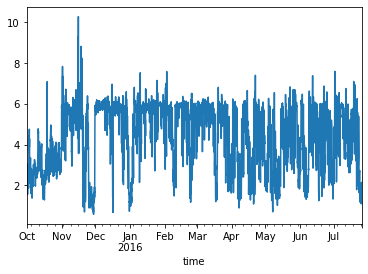

In [13]:
buck.rh.plot()

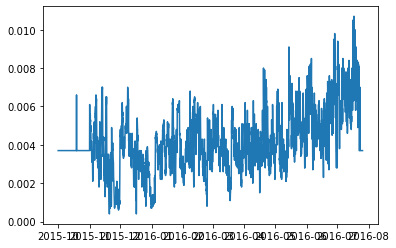

In [14]:
import matplotlib.pyplot as plt
plt.plot(buck.index, mr)

In [ ]:
lw = lw_clr.dilleyobrien1998(buck.airtemp, buck.rh)
lw.plot()

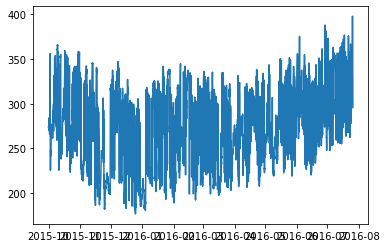

In [16]:
plt.plot(buck.index, buck.LWRadAtm)

In [17]:
buck['LWRadAtm'] = lw
buck = buck.drop(columns=['rh'])

In [18]:
# Select certain dates to bypass summa issues

# Selecting rows between Nov 8, 2015, and June 1, 2016
start_date = '2015-10-01'
end_date = '2016-06-01'

# buck = buck.loc[start_date:end_date]

In [19]:
# Convert dataframe to xarray
dsx = buck.to_xarray()

# Loop through variables and add attributes from template forcing file
for data_var in dsx:
    dsx[data_var].attrs = template[data_var].attrs
    
# Add hru dimension
dsx = dsx.expand_dims(dim={'hru':1})

In [20]:
# Add gap-filled and datastep variables
dsx['gap_filled'] = xr.DataArray(np.ones((1,dsx.time.shape[0])),dims = ['hru','time'])
dsx['data_step'] = 3600 # 3600 seconds for 1hr timesteps

# Transpose gap filled variable to match dimensions with the rest
dsx['gap_filled'] = dsx['gap_filled'].T

# Convert all to float64
for var in dsx.data_vars:
    dsx[var] = dsx[var].astype(np.float64)
    
# Set hruID based on template
dsx['hruId'] = (xr.DataArray(np.ones((1))*template['hruId'].values,dims = ['hru'])).astype(np.int32)

In [21]:
count = 0
for var in dsx.data_vars:
    print(var,count)
    count += 1
    if count <= 7:
        attribs = dsx[var].attrs
        arr_t = dsx[var].values.T
        dsx[var] = xr.DataArray(dims = ['time','hru'],data = arr_t)
        dsx[var].attrs = attribs
dsx

airtemp 0
spechum 1
pptrate 2
SWRadAtm 3
LWRadAtm 4
windspd 5
airpres 6
gap_filled 7
data_step 8
hruId 9


<xarray.Dataset>
Dimensions:     (time: 7177, hru: 1)
Coordinates:
  * time        (time) datetime64[ns] 2015-10-01 ... 2016-07-26
Dimensions without coordinates: hru
Data variables:
    airtemp     (time, hru) float64 281.3 280.8 280.5 ... 286.2 285.5 285.1
    spechum     (time, hru) float64 0.0037 0.0037 0.0037 ... 0.0037 0.0037
    pptrate     (time, hru) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SWRadAtm    (time, hru) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    LWRadAtm    (time, hru) float64 208.8 207.3 206.5 ... 223.4 221.2 219.8
    windspd     (time, hru) float64 2.07 2.457 2.633 ... 0.9633 0.7915 0.5137
    airpres     (time, hru) float64 8.71e+04 8.71e+04 ... 8.76e+04 8.76e+04
    gap_filled  (time, hru) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    data_step   float64 3.6e+03
    hruId       (hru) int32 1001

In [23]:
dsx.to_netcdf('../forcings/buck_wrf_eLW_2016.nc',
                        encoding = {"time":
                                        {'dtype' : 'float64',
                                         'units' : 'hours since 1990-01-01 00:00:00',
                                         'calendar' : 'standard'}})

In [59]:
data = xr.open_dataset('../forcings/buck_wrf_2016.nc')
data

<xarray.Dataset>
Dimensions:     (time: 7177, hru: 1)
Coordinates:
  * time        (time) datetime64[ns] 2015-10-01 ... 2016-07-26
Dimensions without coordinates: hru
Data variables:
    airtemp     (time, hru) float64 ...
    spechum     (time, hru) float64 ...
    pptrate     (time, hru) float64 ...
    SWRadAtm    (time, hru) float64 ...
    LWRadAtm    (time, hru) float64 ...
    windspd     (time, hru) float64 ...
    airpres     (time, hru) float64 ...
    gap_filled  (time, hru) float64 ...
    data_step   float64 ...
    hruId       (hru) int32 ...

In [16]:
nan_variables = {}
    
for variable in data.variables:
    nan_count = data[variable].isnull().sum().item()
    if nan_count > 0:
        nan_variables[variable] = nan_count
        
    
if nan_variables:
    print("Variables with NaN values:")
    for variable, count in nan_variables.items():
        print(f"{variable}: {count} NaN values")
else:
    print("No NaN values found in any variable.")

No NaN values found in any variable.


In [17]:
print(data.LWRadAtm.min())

<xarray.DataArray 'LWRadAtm' ()>
array(176.8639)
